## Football Index market exploratory data analysis

Some exploratory data analysis around the Football Index market, examining the market as an investment vehicle, and testing of basic quantitative trading strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
import utils

First we import and wrangle our data. We slice off and solely assess the top 200 players by price. Since the football index is an extremely immature market, analysis would be most informative if run on player stocks which have a degree of liquidity surrounding them (i.e. the players with the highest market caps). This will hopefully allow us to pick up more insights from price trends and patterns with less random noise.

In [2]:
# Import and organise dataframe
df = pd.read_csv('Q32019_present.csv')
df['Date'] = pd.to_datetime(df['Date'])

start_date = df['Date'].min()
end_date = df['Date'].max()

df.set_index(['Date', 'PlayerName'], inplace=True)
df.sort_index(level=0, inplace=True)

# Calculate log returns variables
df['daily_log_returns'] = df['EndofDayPrice'].apply(np.log).groupby(level=1).diff(1)
df['daily_mkt_log_returns'] = df['ave_mkt_price'].apply(np.log).groupby(level=1).diff(1) 

# Slice off the top 200 players in terms of price on the index
first_day = df.loc[(start_date, slice(None)), :]
top200_mask = first_day.nlargest(200, 'EndofDayPrice').index.droplevel(0).values
top200_full = df.loc[(slice(None), top200_mask), :]

# Seperate train and test sets
top200 = df.loc[:'2020-07-01', :]
out_of_sample = df.loc['2020-07-01':, :]

In [3]:
# Set plot style
style.use('seaborn-darkgrid')

### Initial exploratory plots
First, to give a sense of how the Football index market is faring, we will create a pseudo-market portfolio out of the stocks listed on Football Index (FIT), and compare this to analogous stock market data, in the S&P500 tracking ETF (SPY). 

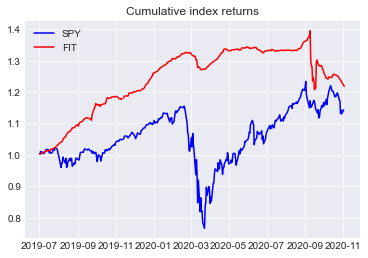

In [4]:
# Comparing to SP500
SPY = yf.Ticker('SPY')
SPY_history = SPY.history(start=start_date, end=end_date)['Close']  # Care don't overuse, works based on scraping yahoo data
SPY_log_returns = SPY_history.apply(np.log).diff(1)
SPY_cum_returns = SPY_log_returns.cumsum().apply(np.exp)

# Extract index price
index_price = df.groupby(level=0)['ave_mkt_price'].head(1).values
# Football index tracker fund (FIT) (comprising of top200)
FIT_log_returns = df['daily_mkt_log_returns'].groupby(level=0).head(1).droplevel(1)
FIT_cum_returns = FIT_log_returns.cumsum().apply(np.exp)

# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_cum_returns.index, SPY_cum_returns, color='b', label='SPY')
ax.plot(FIT_cum_returns.index, FIT_cum_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Cumulative index returns');

Considering cumulative index returns, things look positive for the football index, with the market weathering the global covid-19 shutdown extremely well, and beating the SPY by around 10% over the period.

When considering solely daily returns below, the FIT also significantly beats the SPY in terms of Sharpe ratio. In a turbulent year like 2020, a Sharpe ratio of 1.5 would be considered very good for most trading strategies in real asset markets. (Sharpe ratio measures risk adjusted return on a security, a higher Sharpe ratio is better and indicates an asset's expected returns are high when compared to its volatility. You can read more about this here: https://web.stanford.edu/~wfsharpe/ws/wi_perf.htm#:~:text=The%20annualized%20Sharpe%20Ratio%20is,the%20square%20root%20of%2012)

SPY annualised Sharpe ratio: 0.4881077967546276
FIT annualised Sharpe ratio: 1.5103478268017805


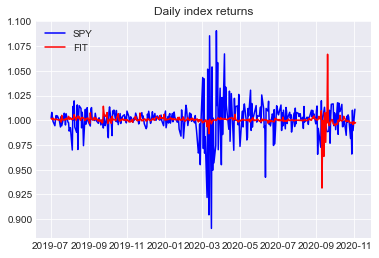

In [5]:
# Benchmark Sharpe ratios

# First generate daily returns
SPY_daily_returns = SPY_log_returns.apply(np.exp)
FIT_daily_returns = FIT_log_returns.apply(np.exp)

SPY_sharpe = utils.gen_daily_sharpe(SPY_daily_returns)
SPY_ann_sharpe = SPY_sharpe * np.sqrt(253)  # On average 253 trading days in a year
print('SPY annualised Sharpe ratio: ' + str(SPY_ann_sharpe))
    
FIT_sharpe = utils.gen_daily_sharpe(FIT_daily_returns)
FIT_ann_sharpe = FIT_sharpe * np.sqrt(365)  # Football index is tradable all year round
print('FIT annualised Sharpe ratio: ' + str(FIT_ann_sharpe))


# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_daily_returns.index, SPY_daily_returns, color='b', label='SPY')
ax.plot(FIT_daily_returns.index, FIT_daily_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Daily index returns');

Additionally, if you were seeking to diversify a current portfolio of shares by buying into Football Index player stocks, the S&P, and therefore by extention global stock markets, do not appear to correlate atall with football index prices. Pearson correlation between the SPY and FIT daily returns is around 0.13.

In [6]:
# Align daily FIT and SPY returns by date and generate correlation matrix
temp = pd.DataFrame(SPY_daily_returns).join(FIT_daily_returns, how='inner').dropna()
corr_matrix = np.corrcoef(temp.iloc[:,0], temp.iloc[:,1])
print('Daily returns corr coefficient: ' + str(corr_matrix[1,0]))

Daily returns corr coefficient: 0.12969296634735483


Daily returns on the FIT are distributed quite tightly, however as always with security returns in any market, fat tail risk is present. Large outliers are present (marked by pink arrows) when examining historic daily returns far more frequently than would be if daily returns followed a normal, or even log normal distribution.

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


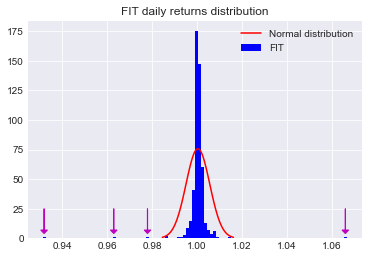

In [7]:
# KDE plots (kind of too many plots but whatever...)
fig, ax = plt.subplots()
ax.hist(FIT_daily_returns, bins=100, label='FIT', color='b')

mu = FIT_daily_returns.mean()
sigma = FIT_daily_returns.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, norm.pdf(x, mu, sigma), label='Normal distribution', color='r')

# Highlight outlying returns
def gen_arrows(x_values, ax):
    for x_val in x_values:
        ax.arrow(x_val, 25, 0, -18, width=0.0001, head_width=0.003, head_length=3, color='m')

outliers = [1.066, 0.978, 0.963, 0.932]
gen_arrows(outliers, ax)
    
ax.set_title('FIT daily returns distribution')
ax.legend();

#### Considering beta dispersion in FI 
How closely do individual player prices follow the overall market?

Player stock betas are generally centered very close to 0. While returns across the board have an upward bias across the sample, individual player stocks appear to move fairly independently, with the outlying high market betas shown in the plot below probably being driven by random chance far more than other factors. This is possibly due to the nature of the underlying drivers for football index stock prices. Fundamental value will change based on performance in matches, and in football matches (excluding draws) one team wins while another loses. That means one set of players will perform well  while others will struggle. Perhaps more importantly, there is little institutional trading occuring on the index to make sure all player prices keep pace with macro market movements (Football Index has some of their own dedicated market makers, but prices are clearly not very efficient yet). This may offer some explanation to this phenomenon.

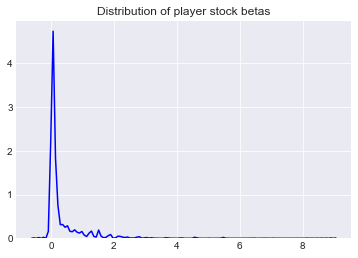

In [8]:
# Gen cov matrix and slice off the useful values
cov = df.groupby(level=1)[['daily_returns', 'daily_mkt_returns']].cov()
cov = cov.loc[(slice(None), 'daily_mkt_returns'), 'daily_returns']

cov.index = cov.index.droplevel(1)
mkt_beta = cov / (df.groupby(level=1)['daily_returns'].std() ** 2)

# PLOT: Market beta dispersion
fig, ax = plt.subplots()
sns.kdeplot(mkt_beta.dropna(), ax=ax, legend=False, color='b')
ax.set_title('Distribution of player stock betas');

We also consider, given FI is an immature market, pricing affectations may well occur predictably on days of the week (Drawing on inspiration from Gibbons and Hess (1981) https://www.jstor.org/stable/2352725). Unsurprisingly, larger market movements tend to occur on Saturdays, while returns are much more stable early in the week. Strangely, more severe movements also appear to occur more on Thursdays, this may again be due to our small sample size though. 

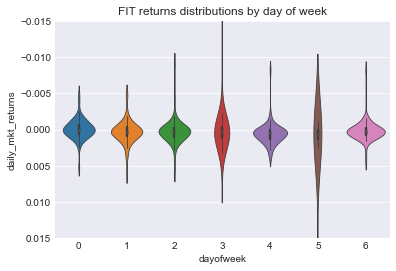

In [9]:
# Consider Business day effects on FI...
df['dayofweek'] = df.index.get_level_values(0)
df['dayofweek'] = df['dayofweek'].dt.weekday

# Extract day of week from index
mkt_returns = df.groupby(level=0)[['daily_mkt_returns', 'dayofweek']].head(1)
mkt_returns.index = mkt_returns.index.droplevel(level=1)

# PLOT: Day of week trends
fig, ax = plt.subplots()
ax.set_title('FIT returns distributions by day of week')
sns.violinplot(x="dayofweek", y='daily_mkt_returns', data=mkt_returns, linewidth=0.8, ax=ax)

# Zoom into plot
#ax.yaxis.zoom(2);
plt.ylim(0.015, -0.015);

## Scouting basic quant strategy

Is pricing inefficient enough in Football Index to make basic quantitative strategy profitable (at least on paper)?

Note we only consider the following strategies among the highest priced 200 players. FI is already an extremely illiquid market even without considering less popular stocks at the lower end of the market. Slippage and trading costs will regardless hit these strategies very hard, so for relevance we only consider trading in the top 200 players. 

##### STRATEGY 1: Price Momentum

Players are placed in a long-only portfolio if their daily returns across the lookback period are among the top 15 highest. (Inspired by Carhart, 1997 https://doi.org/10.1111/j.1540-6261.1997.tb03808.x)

C:\Users\micha\Documents\Quant\football_index\utils.py:70: RuntimeWarning: invalid value encountered in greater_equal
  portfolio_df[portfolio_df.values >= cutoff.values.reshape(len(cutoff),1)] = 1
C:\Users\micha\Documents\Quant\football_index\utils.py:71: RuntimeWarning: invalid value encountered in less
  portfolio_df[portfolio_df.values < cutoff.values.reshape(len(cutoff),1)] = 0


Optimal: 
{'holding_period': 14, 'lookback_window': 21, 'test_period_return': 1.0018508582672287}
{'Combination 0': {'holding_period': 14, 'lookback_window': 3, 'test_period_return': 0.9968477919123816}, 'Combination 1': {'holding_period': 14, 'lookback_window': 7, 'test_period_return': 0.9975545358384325}, 'Combination 2': {'holding_period': 14, 'lookback_window': 14, 'test_period_return': 1.0014016869567077}, 'Combination 3': {'holding_period': 14, 'lookback_window': 21, 'test_period_return': 1.0018508582672287}, 'Combination 4': {'holding_period': 21, 'lookback_window': 3, 'test_period_return': 0.9965606613609402}, 'Combination 5': {'holding_period': 21, 'lookback_window': 7, 'test_period_return': 0.9971867732178712}, 'Combination 6': {'holding_period': 21, 'lookback_window': 14, 'test_period_return': 0.998866742087886}, 'Combination 7': {'holding_period': 21, 'lookback_window': 21, 'test_period_return': 1.001584453357694}}
Strategy daily Sharpe: 0.09590592533098524


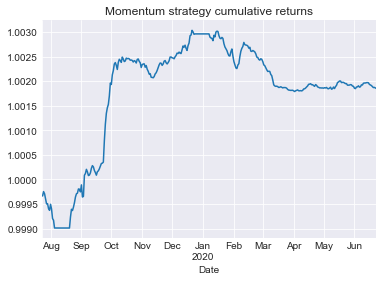

In [10]:
# STRATEGY 1: Price momentum
data = top200
strategy = utils.momentum_strat

param_grid = {'lookback_window': [3, 7, 14, 21],
              'holding_period': [14, 21]}


results, optimal_params = utils.custom_grid_search(data, strategy, param_grid)
print(results)

results = utils.momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

##### STRATEGY 2: Mean reversion
Buy player stocks which have fallen most severely during lookback period. (Inspired by Poterba and Summers (1988) https://doi.org/10.1016/0304-405X(88)90021-9)

C:\Users\micha\Documents\Quant\football_index\utils.py:106: RuntimeWarning: invalid value encountered in greater
  portfolio_df[portfolio_df.values > cutoff.values.reshape(len(cutoff),1)] = 0
C:\Users\micha\Documents\Quant\football_index\utils.py:107: RuntimeWarning: invalid value encountered in less_equal
  portfolio_df[portfolio_df.values <= cutoff.values.reshape(len(cutoff),1)] = 1


Optimal: 
{'holding_period': 21, 'lookback_window': 7, 'test_period_return': 1.0021902874160316}
{'Combination 0': {'holding_period': 14, 'lookback_window': 3, 'test_period_return': 1.0019457416764208}, 'Combination 1': {'holding_period': 14, 'lookback_window': 7, 'test_period_return': 1.0010784310590974}, 'Combination 2': {'holding_period': 21, 'lookback_window': 3, 'test_period_return': 1.001203376643292}, 'Combination 3': {'holding_period': 21, 'lookback_window': 7, 'test_period_return': 1.0021902874160316}}
Strategy daily Sharpe: 0.1047413150772568


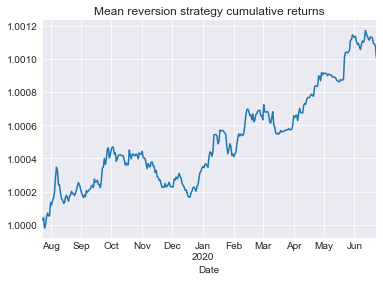

In [11]:
# STRATEGY 2: Mean reversion
# Find biggest losers in past x period, and long them. # This is a bad strat but holding periods tell us something???
data = top200
strategy = utils.mean_reversion
param_grid = {'lookback_window': [3, 7],
              'holding_period': [14, 21]}

results, optimal = utils.custom_grid_search(data, strategy, param_grid)
print(results)

results = utils.mean_reversion(data, param_dict=optimal_params)
results.plot(title='Mean reversion strategy cumulative returns') # TODO: Get params returning sharpe, then vis results

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

#### STRATEGY 3: Post divident drift
Buy a players stock after a dividend is issued.
(Inspired Bernard and Thomas (1989), https://doi.org/10.2307/2491062)

Optimal: 
{'holding_period': 21, 'test_period_return': 1.0051572788912195}
{'Combination 0': {'holding_period': 14, 'test_period_return': 1.0050794211750835}, 'Combination 1': {'holding_period': 21, 'test_period_return': 1.0051572788912195}}
Strategy daily Sharpe: 0.23774573545840347


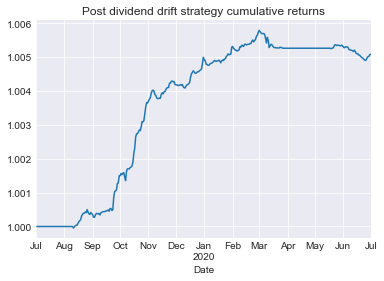

In [12]:
# STRATEGY 3: Post div. drift
data = top200
strategy = utils.post_div_drift
param_grid = {'holding_period': [14, 21]}

results, optimal = utils.custom_grid_search(data, strategy, param_grid)
print(results)

results = utils.post_div_drift(data, param_dict=optimal_params)
results.plot(title='Post dividend drift strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

#### STRATEGY 4.1: Simple moving average cross (SMAC)

The SMA cross strategy is another pseudo-momentum following strategy. We buy when 2 moving averages calculated over a lookback window of player stock price cross over one another. A moving average cross is used as a directional indicator of price. We sell the player when the moving averages cross back over eachother. 

Optimal: 
{'duration_MA1': 22, 'duration_MA2': 22, 'test_period_return': 1.0}
Strategy daily Sharpe: nan


C:\Users\micha\Documents\Quant\football_index\utils.py:16: RuntimeWarning: invalid value encountered in double_scalars
  daily_sharpe = (r_pf - r_f) / sigma


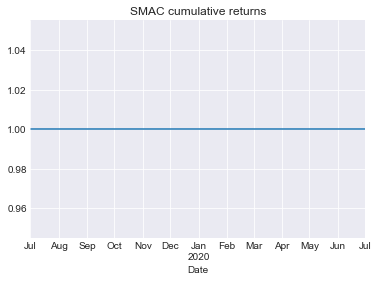

In [13]:
# STRATEGY 4.1: SMAC (single player)
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = utils.SMAC
param_grid = {'duration_MA1': [22],
              'duration_MA2': [5, 22]}

results, optimal_params = utils.custom_grid_search(data, strategy, param_grid)


results = utils.SMAC(data, param_dict=optimal_params)
results.plot(title='SMAC cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

#### STRATEGY 4.2: EMAC

The EMA cross strategy is near identical to the SMA cross, but is done using exponentially weighted moving averages.

Optimal: 
{'duration_EMA1': 3, 'duration_EMA2': 7, 'test_period_return': 1.0259508962885309}
Strategy daily Sharpe: 0.021579561159241034


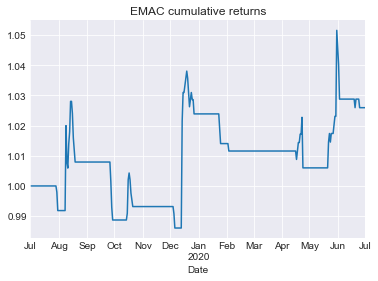

In [14]:
# STRATEGY 4.2: EMAC
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = utils.EMAC
param_grid = {'duration_EMA1': [3, 5, 7, 10, 15, 20],
              'duration_EMA2': [5, 7, 10, 15, 20, 25, 30]}

results, optimal_params = utils.custom_grid_search(data, strategy, param_grid)


results = utils.EMAC(data, param_dict=optimal_params)
results.plot(title='EMAC cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

### Out of sample testing

None of the above strategies tested exhibit spectacular results. However, our most promising strategy appears to be just using vanilla momentum to determine player stock picks. Therefore, we use the optimal lookback and holding periods found in our training set, and evaluate our trading system on a more recent out-of-sample set.

C:\Users\micha\Documents\Quant\football_index\utils.py:70: RuntimeWarning: invalid value encountered in greater_equal
  portfolio_df[portfolio_df.values >= cutoff.values.reshape(len(cutoff),1)] = 1
C:\Users\micha\Documents\Quant\football_index\utils.py:71: RuntimeWarning: invalid value encountered in less
  portfolio_df[portfolio_df.values < cutoff.values.reshape(len(cutoff),1)] = 0


Strategy daily Sharpe: -0.14318640648380848


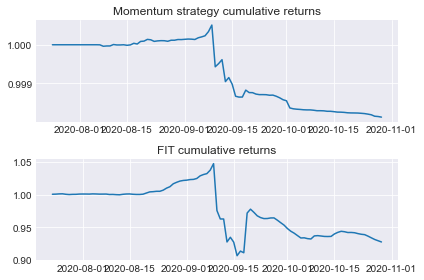

In [15]:
# OUT OF SAMPLE TESTING: Price momentum
data = out_of_sample
strategy = utils.momentum_strat

optimal_params =  {'holding_period': 14,
                   'lookback_window': 21}

# Plot results
fig, ax = plt.subplots(2, 1)

results = utils.momentum_strat(data, param_dict=optimal_params)
ax[0].plot(results)
ax[0].set_title('Momentum strategy cumulative returns')

# Plot index benchmark
start = results.index.min()
end = results.index.max()

OOS_log_returns = FIT_log_returns[start:end]
OOS_cum_returns = OOS_log_returns.cumsum().apply(np.exp)

ax[1].plot(OOS_cum_returns[start:end])
ax[1].set_title('FIT cumulative returns')

plt.tight_layout()

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = utils.gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

As seen above, in our out-of-sample test, our momentum strategy performs similarly to a de-leveraged market portfolio, and offers us no significant additional value to re-imburse the trading costs associated with rebalancing at the end of each holding period.

### Conclusion

In conclusion, none of these strategies seem even close to beating the Football Index market due to the massive costs associated with trading on the index, in both spread (the delta between the bid and ask price of a player), and commissions taken by Football Index itself. Even estimating these costs extremely conservatively, takes all the above strategies into the red. 

The next best option to consider then is to buy and hold a portfolio of players across the index, but this trading position is essentially just like buying a proxy for stock in Football Index itself. Hence, if you think that the market has long run prospects, or will continue to gain in popularity, you should buy in and hold a selection of players. When doing this position you should be prepared to weather the likely future moments of extreme volatlility in the market. If you do not strongly believe the Football Index has more long run growth to come, trying to play for value with players using a systematic approach is probably a waste of time due to the large trading costs associated with it.